# Implementacja pojedynczego neuronu, gdzie:
<ul>
    <li>x - wektor cech (wektor liczb, które opisują dany (jeden) obiekt).</li>
    <li>w - wektor wag - wektor, który każdej cesze nadaje odpowiednią wagę.</li>
    <li>b - bias, **skalar** determinujący jaką wartość powinno przyjąć wyrażenie $\vec{w}^T\vec{x} + b$, kiedy wektor $\vec{x}$ składa się z samych zer. 
</ul>
Jako funkcję aktywacji neuronu przyjęty został tangens hiperboliczny.

In [1]:
import numpy as np

def neuron(w, x, b):
    result = 0
    for i in range(len(w)):
        value = w[i] * x[i]
        result += value
    result += b
    return np.tanh(result)

print(neuron([1,2,3], [1,1,1], 2))
print(neuron([1,2,3], [0,0,0], 2))
print(neuron([-0.26,1.745,-0.8], [.12,-0.1,.23], 0.45))
print(neuron([-0.26,1.745,-0.8], [.12,-0.1,.23], 0.1))

0.9999997749296758
0.9640275800758169
0.06022702073283583
-0.2818586693207789


# Softmax

In [2]:
def softmax(z): # funkcja zamieniająca dowolny wektor na wektor, którego suma elementów wynosi 1 
    e = np.exp(z)
    return e / np.sum(e)

print(softmax([1.0, 1.0, 2.0]))
print(softmax([0.0, 1.0]))
print(softmax([-11.0, 18.0]))
print(softmax([1,2,3,4,5]))

[0.21194156 0.21194156 0.57611688]
[0.26894142 0.73105858]
[2.54366565e-13 1.00000000e+00]
[0.01165623 0.03168492 0.08612854 0.23412166 0.63640865]


In [3]:
input_dim = 2 # ilość cech na wejściu
hidden_dim = 3 # ilość neuronów w warstwie ukrytej
output_dim = 2 # ilość neuronów w warstwie wyjściowej


np.random.seed(0)
x = np.random.randn(input_dim, 1) # stworzenie wektora cech obiektu

W1 = np.random.randn(hidden_dim, input_dim)  # stworzenie macierzy wag, wiersze - neurony ukryte, kolumny - cechy wejściowe
b1 = np.zeros((hidden_dim, 1)) # stworzenie wektora biasów dla neuronów warstwy ukrytej
W2 = np.random.randn(output_dim, hidden_dim) # stworzenie macierzy wag, wiersze - neurony wyjściowe, kolumny - neurony z warstwy ukrytej
b2 = np.zeros((output_dim, 1)) # stworzenie wektora biasów dla neuronów warstwy wyjściowej


# Faza Feedforward, gdzie:

$z1 = W1 \cdot x + \vec{b_h}$

$a1 = tanh(z1)$

$z2 = W2 \cdot a1 + \vec{b_o}$

$a2 = softmax(z2)$


In [4]:
def forward_phase(W1, b1, W2, b2, x): # funkcja wyznaczająca wyjście sieci dla wektora cech x
    z1 = np.dot(W1, x) + b1
    a1 = np.tanh(z1)
    
    z2 = np.dot(W2, a1) + b2
    a2 = softmax(z2)
    
    return a2

def predict(W1, b1, W2, b2, x): 
    probs = forward_phase(W1, b1, W2, b2, x) # obliczenie prawdopodobieństwa przynależności do klas
    return np.argmax(probs)  # wybór klasy, której prawdopodobieństwo jest większe

print("Prawdopodobieństwa wygenerowane przez każdy z wyjściowych neuronów")
print(forward_phase(W1, b1, W2, b2, x))
print("\nWybór klasy (neuronu, licząc od 0), który ma największe prawdopodobieństwo")
print(predict(W1, b1, W2, b2, x))

Prawdopodobieństwa wygenerowane przez każdy z wyjściowych neuronów
[[0.13367536]
 [0.86632464]]

Wybór klasy (neuronu, licząc od 0), który ma największe prawdopodobieństwo
1


# Pełna sieć neuronowa 2-warstwowa służąca do odseparowania kółek czerwonych od niebieskich

## Wygenerowanie problemu

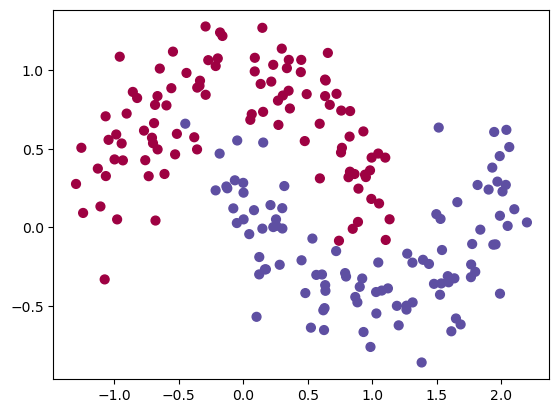

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib

%matplotlib inline
np.random.seed(0)

# funkcja, która używając wyuczonego modelu wyznaczy przynależność do odpowiedniej klasy każdego piksela na obrazku z osobna
def plot_boundary(pred_func):
    x_min, x_max = X[0,:].min() - .5, X[0,:].max() + .5
    y_min, y_max = X[1,:].min() - .5, X[1,:].max() + .5
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()].T)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[0,:], X[1,:], c=y, cmap=plt.cm.Spectral)

X, y = sklearn.datasets.make_moons(200, noise=0.17)
X = X.T
y = y.T
plt.scatter(X[0,:], X[1,:], s=40, c=y, cmap=plt.cm.Spectral)

## Uczenie sieci

Uczenie klasyfikatora odbywa się w sposób iteracyjny, w którym następujące 3 kroki zostają wykonane wielokrotnie w celu wyznaczenia i zaaplikowania poprawek wag modelu.

<ol>
    <li>Wyznaczenie wartości wyjść sieci z użyciem procedury feedforward dla zadanych cech oraz aktualnych parametrów, aby sprawdzić wynik sieci</li>
    <li>Obliczenie różnicy pomiędzy tym co generuje sieć wykorzystując aktualne wagi, a wynikiem oczekiwa (funkcja kosztu)</li>
    <li>Poprawienie wag z użyciem propagacji wstecznej. Różnica między wartością wygenerowaną, a wartością oczekiwaną to błąd sieci. Błąd ten zostaje wykorzystany do wyznaczenia poprawek poszczególnych wag poprzez obliczenie pochodnych cząstkowych (wagi silnie przyczyniające się do generowania błednej odpowiedzi powinny być mocniej zmienione). </li>
</ol>

Proces oceny błedu i obliczania poprawek wag sieci (z użyciem algorytmu propagacji wstecznej), a także aktualizacji wartości poszczególnych parametrów w naszej architekturze przebiega z użyciem następujących równań:

Wyznaczenie poprawek:

$\delta_3 = \hat{y} - y$

$\delta_2 = W_2 \delta_3 * (1 - tanh^2z_1)$

$\frac{\partial L}{\partial W_2} = \delta_3a_1^T$

$\frac{\partial L}{\partial b_2} = \delta_3$

$\frac{\partial L}{\partial W_1} = \delta_2x^T$

$\frac{\partial L}{\partial b_1} = \delta_2$

Aktualizacja parametrów:

$W_2 = W_2 - learningrate * \frac{\partial L}{\partial W_2}$

$b_2 = b_2 - learningrate * \frac{\partial L}{\partial b_2}$

$W_1 = W_1 - learningrate * \frac{\partial L}{\partial W_1}$

$b_1 = b_1 - learningrate * \frac{\partial L}{\partial b_1}$

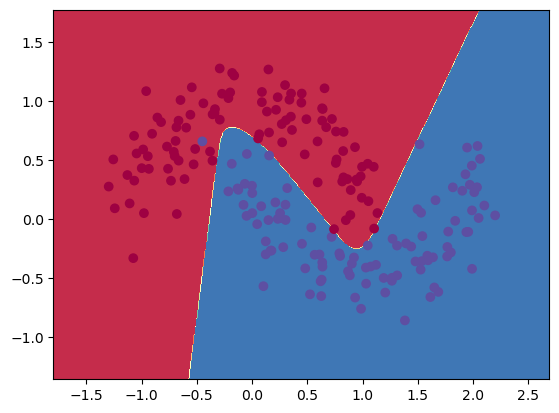

In [6]:
num_examples = len(X.T) # ilość przykładów w zbiorze uczącycm
nn_input_dim = 2 # wymiarowość warstwy wejściowej
nn_output_dim = 2 # wymiarowość warstwy wyjściowej

learning_rate = 0.01 # stała uczenia

def predict_class(model, x):
    z1 = model['W1'].dot(x) + model['b1']
    a1 = np.tanh(z1)
    z2 = model['W2'].dot(a1) + model['b2']
    softmax_probs = np.exp(z2) / np.sum(np.exp(z2), axis=0, keepdims=True)
    
    return np.argmax(softmax_probs, axis=0)

def build_model(nn_hdim, iterations=20000):
    np.random.seed(0)
    W1 = np.random.randn(nn_hdim, nn_input_dim)  # losowa macierz wag miedzy warstwą wejściową a ukrytą
    b1 = np.zeros((nn_hdim, 1))                  # wektor biasów na warstwie ukrytej
    W2 = np.random.randn(nn_output_dim, nn_hdim) # losowa macierz wag między warstwą ukrytą a wyjściową
    b2 = np.zeros((nn_output_dim, 1))            # wektor biasów na warstwie wyjściowej
    
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    
    #iteracyjne poprawianie wag
    for i in range(0, iterations):
        # wyznaczenie wyjścia sieci dla wszystkich obiektów    
        z1 = model['W1'].dot(X) + model['b1']
        a1 = np.tanh(z1)                                  # wartości w neuronach warstwy ukrytej 
        z2 = model['W2'].dot(a1) + model['b2']
        softmax_probs = np.exp(z2) / np.sum(np.exp(z2), axis=0, keepdims=True) # wartości w neuronach warstwy wyjściowej
        
        # propagacja wsteczna błędów, wyznaczenie poprawek wag
        delta3 = softmax_probs
        delta3[y,range(num_examples)] -= 1
        dW2 = delta3.dot(a1.T)                            # obliczanie poprawki macierzy wag między warstwą ukrytą a wyjściową
        db2 = np.sum(delta3, axis=1, keepdims=True)       # obliczanie poprawki wektora biasu w warstwie wyjściowej
        delta2 = W2.T.dot(delta3) * (1 - np.power(a1, 2))
        dW1 = np.dot(delta2, X.T)                         # obliczanie poprawki macierzy wag między wejściem a warstwą ukrytą
        db1 = np.sum(delta2, axis=1, keepdims=True)       # obliczanie poprawki wektora biasu w warstwie ukrytej
        # Zaktualizowanie wag
        model['W1'] += -learning_rate * dW1 # poprawa macierzy wag między warstwą wejściową a ukrytą
        model['b1'] += -learning_rate * db1 # poprawa wektora biasów w warstwie ukrytej
        model['W2'] += -learning_rate * dW2 # poprawa macierzy wag między warstwą ukrytą a wyjściową
        model['b2'] += -learning_rate * db2 # poprawa wektora biasów w warstwie wyjściowej
    return model

model = build_model(3)  # wyznaczenie najlepszego zbiór parametrów
plot_boundary(lambda x: predict_class(model, x)) # narysowanie wyuczonej granicy decyzyjnej